In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-08-28_00-26_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [5]:
#df = df.loc['20190101':'20190701']

In [6]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [7]:
allocs

GC       0.25
YM       0.25
NQ       0.25
ES       0.25
total    1.00
dtype: float64

In [8]:
df.groupby('contract').realizedPNL.sum()

contract
ES    23027.60
GC    -8290.32
NQ    25794.40
YM    29159.80
Name: realizedPNL, dtype: float64

In [9]:
df.realizedPNL.sum()

69691.48

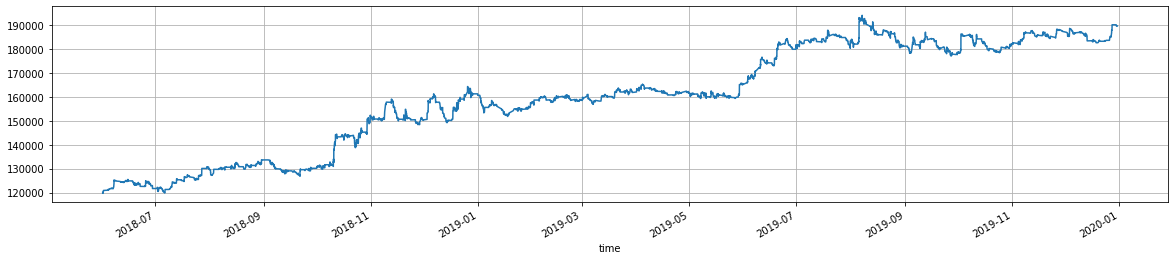

In [10]:
df.cash.plot(figsize=(20,4), grid=True);

In [11]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [12]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     344
 GC    1497
 NQ    2786
 YM     462
 Name: action, dtype: int64,
 5089)

In [13]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.834951
 GC    3.633495
 NQ    6.762136
 YM    1.121359
 Name: action, dtype: float64,
 12.351941747572816)

In [14]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     722.40
GC    3622.74
NQ    5850.60
YM     970.20
Name: commission, dtype: float64

In [15]:
df.commission.sum()

11165.94

In [16]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.37,-11.08,432.21,-268.81,1.61,-9.43,748.0
NQ,0.39,18.52,439.57,-252.91,1.74,17.16,1393.0
YM,0.45,126.23,756.67,-381.07,1.99,130.91,231.0
ES,0.45,133.88,987.68,-558.15,1.77,137.47,172.0
total,0.39,27.39,512.34,-287.21,1.78,24.61,2544.0


In [17]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [18]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,0.018971,0.153038,0.491003,0.649335
GC,0.018971,1.000000,0.138640,0.095560,0.469024
NQ,0.153038,0.138640,1.000000,0.254318,0.681541
YM,0.491003,0.095560,0.254318,1.000000,0.700057
total,0.649335,0.469024,0.681541,0.700057,1.000000


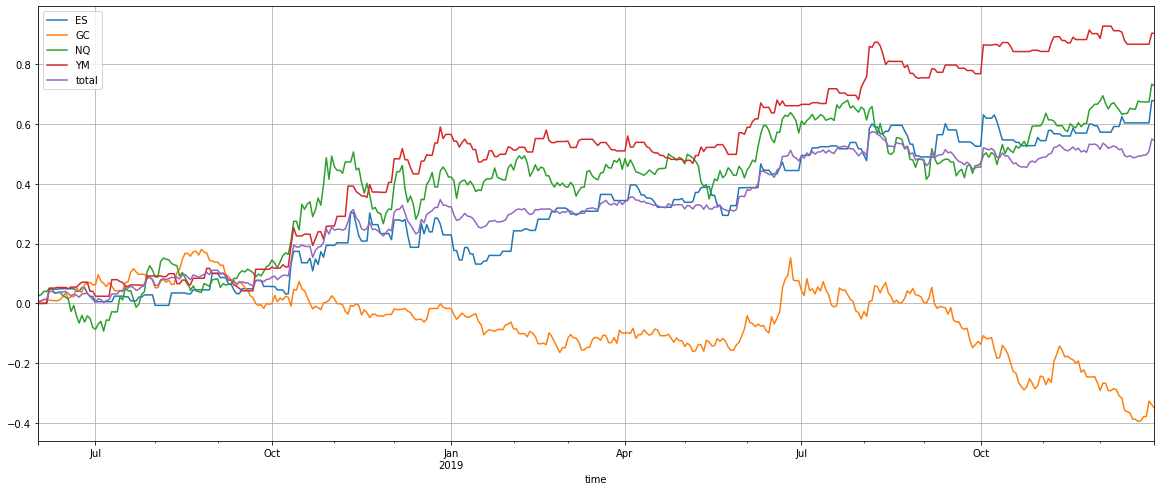

In [19]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

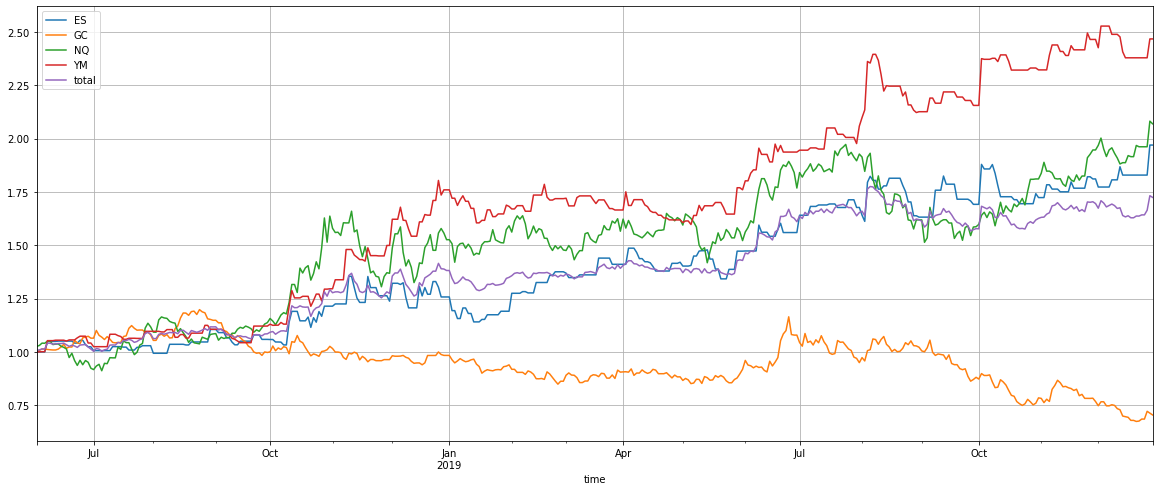

In [20]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [21]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.513627,-0.192804,0.560041,0.737150,0.395425
Cumulative returns,0.969322,-0.295440,1.069007,1.466693,0.724185
Annual volatility,0.336075,0.301782,0.404005,0.293245,0.210679
Sharpe ratio,1.396993,-0.560093,1.301728,2.027384,1.686092
Calmar ratio,3.255707,-0.440896,2.407591,6.436677,3.369846
Stability,0.942021,0.474594,0.783778,0.935314,0.911845
Max drawdown,-0.157762,-0.437300,-0.232615,-0.114523,-0.117342
Omega ratio,1.469123,0.906518,1.252809,1.710695,1.382388
Sortino ratio,2.868537,-0.851625,2.079009,4.548735,3.220344
Skew,2.167302,0.731977,0.392838,2.285307,1.640021


In [22]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,2.40,6.44,-7.66,4.16,1.34
2018-07-31,0.49,1.48,21.03,5.26,7.01
2018-08-31,7.41,6.29,-2.99,0.87,3.02
2018-09-30,-4.22,-13.13,4.89,1.36,-2.89
2018-10-31,14.71,2.88,43.89,15.58,19.08
2018-11-30,1.92,-6.06,-16.37,15.69,-1.36
2018-12-31,1.60,2.03,11.50,17.38,8.41
2019-01-31,-5.32,-4.49,4.29,-4.41,-2.32
2019-02-28,15.53,-8.18,-7.15,2.16,0.42


In [23]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES        97.0
GC       -30.0
NQ       107.0
YM       147.0
total     72.0
dtype: float64

In [24]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-06-20 03:04:00,GC,SELL,1392.50,3445.16
2019-08-05 21:22:30,ES,BUY,2843.00,3408.30
2019-10-02 21:00:00,ES,BUY,2893.75,3320.80
2019-08-05 21:19:00,YM,BUY,25615.00,3190.80
2018-11-08 20:40:00,YM,SELL,26092.00,3180.80
...,...,...,...,...
2018-12-20 12:21:30,ES,BUY,2508.00,-1204.20
2018-12-18 21:49:00,ES,BUY,2559.75,-1204.20
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.20


In [25]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-08-05,0.113610,0.050344,0.035793,0.106360,0.076527
2019-10-02,0.110693,0.029355,0.026633,0.101693,0.067094
2018-12-03,0.067777,0.018849,0.086413,0.081860,0.063725
2018-10-11,0.044580,0.057183,0.068880,0.061913,0.058139
2018-10-10,0.103193,-0.028484,0.045267,0.073053,0.048257
...,...,...,...,...,...
2018-12-10,-0.051947,-0.008989,-0.043147,-0.000780,-0.026216
2018-11-13,-0.038890,0.008344,-0.058287,-0.017613,-0.026611
2019-01-02,-0.050973,-0.020817,-0.012367,-0.022307,-0.026616
